In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import geopandas as gpd
from src.settings import *
from tqdm.auto import tqdm
# import torch
# import pytorch_lightning as pl
# from torch.utils.data.dataloader import DataLoader
# from torch.utils.data.dataset import Dataset
# from pytorch_lightning.loggers import WandbLogger
# import wandb
# from src.models.autoencoder import LitAutoEncoder, LitVAE
import json5 as json
import pickle as pkl
from src.tools.configs import ExperimentConfig, DatasetGenerationConfig
from src.tools.feature_extraction import SpatialDataset
import dataclasses
import gzip
from src.tools.feature_extraction import apply_feature_selection, normalize_df, apply_features_mapping, apply_features_assume
import xgboost as xgb
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import gzip

tqdm.pandas()

In [11]:
dataset_filename = "dataset_2022-01-04_20-50-24_all.pkl.gz"
random_seed = 42

In [12]:
ds_path = FEATURES_DIR / dataset_filename
with gzip.open(ds_path, "rb") as f:
    ds: SpatialDataset = pkl.load(f)

ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'edges_feature_selected': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [13]:
ds_config = ds.config
cities = ds.cities
edges = ds.edges
hexagons = ds.hexagons
hex_agg = ds.hex_agg
hex_agg_normalized = ds.hex_agg_normalized

In [14]:
data = apply_feature_selection(edges, ds_config.featureset_selection)
# data = apply_features_mapping(data, [{
#     "feature": "highway",
#     "mapping": {
#         "motorway_link": "motorway",
#         "primary_link": "primary",
#         "secondary_link": "secondary",
#         "tertiary_link": "tertiary",
#         "trunk_link": "trunk"
#     }
# }])
# data = apply_features_mapping(data, [{
#     "feature": "surface",
#     "mapping": {
#         "asphalt": "paved",
#         "paving_stones": "paved",
#         "concrete": "paved",
#         "concrete_prefabricated": "paved",
#         "compacted": "unpaved",
#         "ground": "unpaved"
#     }
# }])
# data = apply_features_assume(data, {
#       "surface": "paved",
# })
# data = apply_features_mapping(data, [{
#     "feature": "highway",
#     "mapping": {
#         'secondary': 'not_residential', 
#         'tertiary': 'not_residential', 
#         'living_street': 'not_residential', 
#         'primary': 'not_residential', 
#         'unclassified': 'not_residential', 
#         'motorway': 'not_residential', 
#         'trunk': 'not_residential'
#     }
# }])
# data = data.drop(columns="highway_residential")
# data = data.drop(columns="surface_paved")
data

oneway_False  oneway_True  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff             0            1   
                                89215382263ffff             0            1   
                                8921538227bffff             0            1   
                                89215382273ffff             0            1   
                                89215382263ffff             0            1   
...                                                       ...          ...   
Oceania   Australia  Sydney     89be0845cc7ffff             1            0   
                                89be0845c8bffff             1            0   
                                89be0845c83ffff             1            0   
                                89be0844223ffff             0            1   
                                89be0844233ffff             0            1   

                                                 lanes_1  lanes_2  lanes_3  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff        0        1        0   
                                89215382263ffff        0        0        0   
                                8921538227bffff        0        0        0   
                                89215382273ffff        0        0        0   
                                89215382263ffff        0        1        0   
...                                                  ...      ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0        0   
                                89be0845c8bffff        0        0        0   
                                89be0845c83ffff        0        0        0   
                                89be0844223ffff        0        0        0   
                                89be0844233ffff        0        0        0   

                                                 lanes_4  lanes_5  lanes_6  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff        0        0        0   
                                89215382263ffff        0        0        0   
                                8921538227bffff        0        0        0   
                                89215382273ffff        0        0        0   
                                89215382263ffff        0        0        0   
...                                                  ...      ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0        0   
                                89be0845c8bffff        0        0        0   
                                89be0845c83ffff        0        0        0   
                                89be0844223ffff        0        0        0   
                                89be0844233ffff        0        0        0   

                                                 lanes_7  lanes_8  ...  \
continent country    city       h3_id                              ...   
Asia      Kazakhstan Nur-Sultan 89215382263ffff        0        0  ...   
                                89215382263ffff        0        0  ...   
                                8921538227bffff        0        0  ...   
                                89215382273ffff        0        0  ...   
                                89215382263ffff        0        0  ...   
...                                                  ...      ...  ...   
Oceania   Australia  Sydney     89be0845cc7ffff        0        0  ...   
                                89be0845c8bffff        0        0  ...   
                                89be0845c83ffff        0        0  ...   
                                89be0844223ffff        0        0  ...   
                                89be0844233ffff        0        0  ...   

                                         

In [15]:
data["oneway_False"] = 1 - data["oneway_True"]

In [16]:
features = list(ds_config.featureset_selection["features"].keys())
for feature in tqdm(features):
    wide_feature_cols = [col for col in data.columns if feature in col]
    data[feature] = data[wide_feature_cols].idxmax(axis=1).astype("category")
    data[feature][data[wide_feature_cols].sum(axis=1) == 0] = None
    data.drop(columns=wide_feature_cols, inplace=True)

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


In [17]:
# data = pd.concat([
#     data[data["highway"] == "highway_residential"].sample(frac=0.25, random_state=random_seed, replace=False), 
#     data[data["highway"] != "highway_residential"]]
#     )

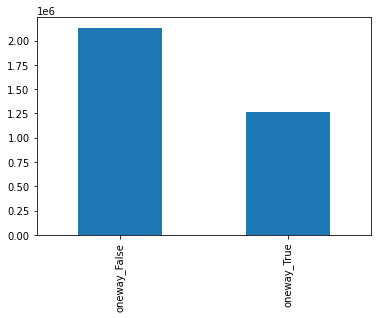

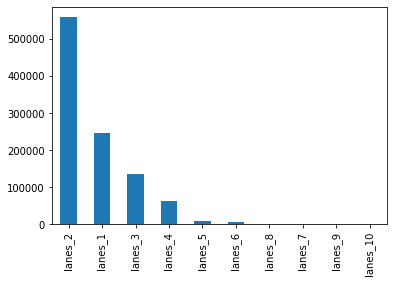

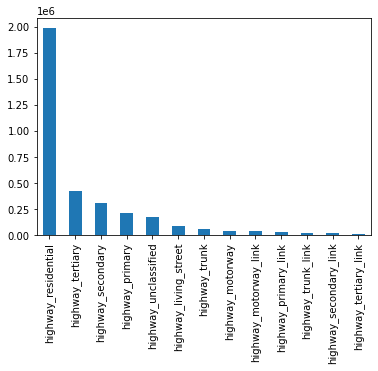

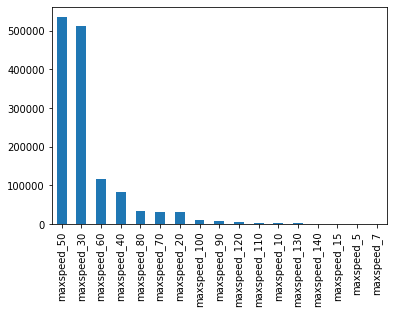

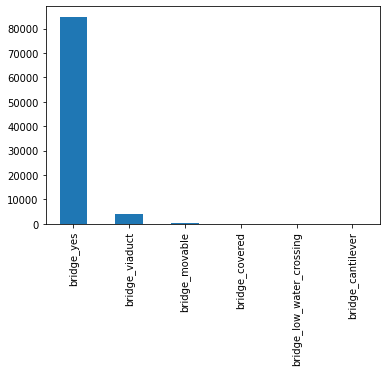

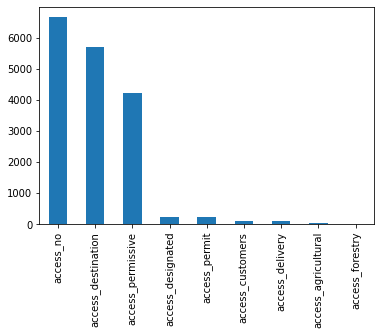

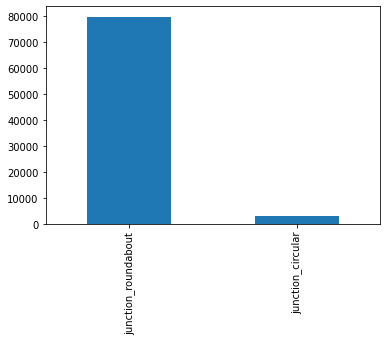

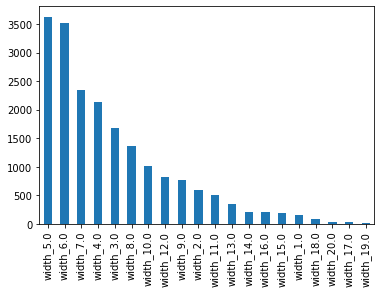

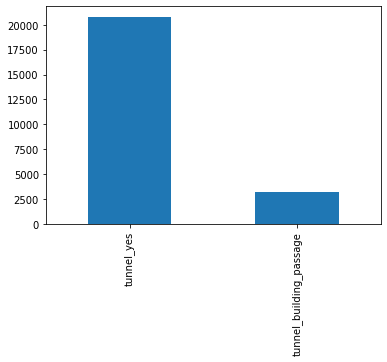

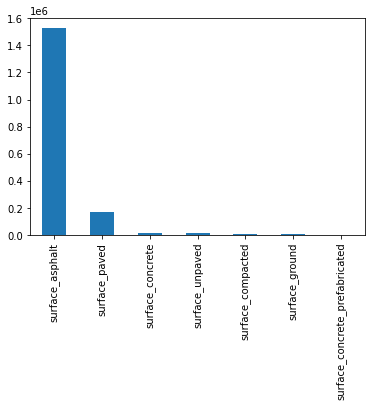

In [18]:
for f in features:
    data[f].value_counts().plot(kind="bar")
    plt.show()

<AxesSubplot:>

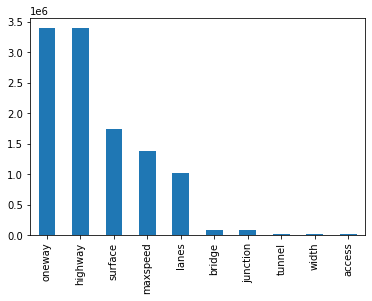

In [19]:
data.notna().sum().sort_values(ascending=False).plot(kind="bar")

In [20]:
features_numeric = ["lanes", "maxspeed", "width"]

for feature in features_numeric:
    data[feature] = data[feature].apply(lambda x: float(x.split("_")[1]) if x is not None else None).astype(float)

In [21]:
# data = data[["oneway", "lanes", "highway", "maxspeed"]]

In [22]:
# target_columns = [c for c in data.columns if 'highway' in c]
target_column = 'highway'
data = data[data[target_column].notnull()]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = data.drop(columns=[target_column])
Y = data[target_column]
y = le.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True, stratify=y)
display(X_train)
display(y_train)

oneway  lanes  \
continent country        city         h3_id                                  
Europe    United Kingdom Glasgow City 891909ac5a7ffff  oneway_False    NaN   
Asia      Turkey         Istanbul     891ec9021b7ffff   oneway_True    NaN   
Europe    Poland         Wrocław      891e2040dcfffff   oneway_True    1.0   
          Greece         Athens       891eda74567ffff   oneway_True    NaN   
          Ireland        Dublin       89182c1751bffff  oneway_False    3.0   
...                                                             ...    ...   
          Serbia         Belgrade     891ef59053bffff  oneway_False    NaN   
          Germany        Berlin       891f18864c7ffff  oneway_False    NaN   
          Poland         Bydgoszcz    891f0b32c6fffff   oneway_True    2.0   
          United Kingdom London       89194ad2a97ffff  oneway_False    NaN   
          Norway         Oslo         8909993a3d3ffff  oneway_False    NaN   

                                                       maxspeed bridge access  \
continent country        city         h3_id                                     
Europe    United Kingdom Glasgow City 891909ac5a7ffff       NaN    NaN    NaN   
Asia      Turkey         Istanbul     891ec9021b7ffff       NaN    NaN    NaN   
Europe    Poland         Wrocław      891e2040dcfffff      50.0    NaN    NaN   
          Greece         Athens       891eda74567ffff       NaN    NaN    NaN   
          Ireland        Dublin       89182c1751bffff      30.0    NaN    NaN   
...                                                         ...    ...    ...   
          Serbia         Belgrade     891ef59053bffff       NaN    NaN    NaN   
          Germany        Berlin       891f18864c7ffff      30.0    NaN    NaN   
          Poland         Bydgoszcz    891f0b32c6fffff      50.0    NaN    NaN   
          United Kingdom London       89194ad2a97ffff      30.0    NaN    NaN   
          Norway         Oslo         8909993a3d3ffff       NaN    NaN    NaN   

                                                      junction  width tunnel  \
continent country        city         h3_id                                    
Europe    United Kingdom Glasgow City 891909ac5a7ffff      NaN    NaN    NaN   
Asia      Turkey         Istanbul     891ec9021b7ffff      NaN    NaN    NaN   
Europe    Poland         Wrocław      891e2040dcfffff      NaN    NaN    NaN   
          Greece         Athens       891eda74567ffff      NaN    NaN    NaN   
          Ireland        Dublin       89182c1751bffff      NaN    NaN    NaN   
...                                                        ...    ...    ...   
          Serbia         Belgrade     891ef59053bffff      NaN    NaN    NaN   
          Germany        Berlin       891f18864c7ffff      NaN    NaN    NaN   
          Poland         Bydgoszcz    891f0b32c6fffff      NaN    NaN    NaN   
          United Kingdom London       89194ad2a97ffff      NaN    NaN    NaN   
          Norway         Oslo         8909993a3d3ffff      NaN    NaN    NaN   

                                                               surface  
continent country        city         h3_id                             
Europe    United Kingdom Glasgow City 891909ac5a7ffff              NaN  
Asia      Turkey         Istanbul     891ec9021b7ffff              NaN  
Europe    Poland         Wrocław      891e2040dcfffff  surface_asphalt  
          Greece         Athens       891eda74567ffff  surface_asphalt  
          Ireland        Dublin       89182c1751bffff  surface_asphalt  
...                                                                ...  
          Serbia         Belgrade     891ef59053bffff              NaN  
          Germany        Berlin       891f18864c7ffff              NaN  
          Poland         Bydgoszcz    891f0b32c6fffff  surface_asphalt  
          United Kingdom London       89194ad2a97ffff              NaN  
          Norway         Oslo         8909993a3d3ffff              NaN  

[

array([5, 3, 8, ..., 6, 5, 0])

In [16]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softmax", 
    random_state=random_seed, 
    n_jobs=-1, 
    use_label_encoder=False, 
    num_class=len(le.classes_), 
    n_estimators=1000, 
    tree_method="gpu_hist", 
    max_depth=10,
    eval_metric="mlogloss",
    enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='mlogloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=8, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, ...)

In [17]:
proba = xgb_classifier.predict_proba(X_test)
y_pred = xgb_classifier.predict(X_test)

In [18]:
from sklearn.metrics import f1_score, classification_report

print("F1 Score", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=le.classes_))

F1 Score 0.3308718039479084
                       precision    recall  f1-score   support

highway_living_street       0.64      0.14      0.23     17270
     highway_motorway       0.60      0.50      0.54     14481
      highway_primary       0.43      0.30      0.36     48428
  highway_residential       0.70      0.97      0.81    397555
    highway_secondary       0.35      0.23      0.28     64685
     highway_tertiary       0.33      0.10      0.15     86446
        highway_trunk       0.43      0.19      0.26     15359
 highway_unclassified       0.36      0.01      0.02     34859

             accuracy                           0.64    679083
            macro avg       0.48      0.30      0.33    679083
         weighted avg       0.57      0.64      0.57    679083



In [19]:
from eli5.sklearn import PermutationImportance
import eli5
# pi = PermutationImportance(xgb_classifier).fit(X_test, y_test)
eli5.show_weights(xgb_classifier)

Weight,Feature
0.3049,lanes
0.2576,oneway
0.2337,maxspeed
0.0593,bridge
0.0515,junction
0.0350,surface
0.0243,tunnel
0.0206,access
0.0131,width


In [20]:
# from tpot import TPOTClassifier
# pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
#                                     random_state=42, verbosity=2, config_dict='TPOT light')
# pipeline_optimizer.fit(X_train, y_train)
# print(pipeline_optimizer.score(X_test, y_test))